In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# setup sql stuff
Base = automap_base()
Base.prepare(engine,reflect = True)
Base.classes.keys()
Measurement = Base.classes.measurement
Station = Base.classes.station
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [6]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# Previous Years vacation days average
print(calc_temps("2017-08-01","2017-08-07"))

[(72.0, 79.25, 83.0)]


(0, 100)

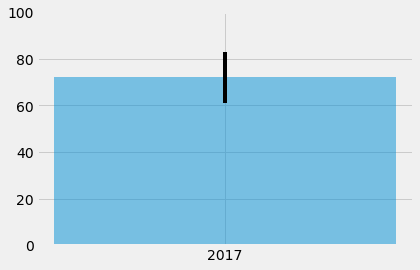

In [7]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
year_temp = calc_temps("2017-08-01","2017-08-07")
plt.bar(['2017'],year_temp[0][0],yerr = year_temp[0][2]-year_temp[0][0],alpha = .5)
plt.ylim(0,100)

### Daily Rainfall Average

In [9]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
start = "2017-01-01"
end = "2017-08-07"
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
#rps = session.query(Measurement.station,func.sum(Measurement.prcp)).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc())
#join = session.query(Measurement, Station).filter(Measurement.station == Station.station).group_by(Measurement.station).all()
sel = [func.sum(Measurement.prcp),Station.name,Station.longitude, Station.latitude,Station.elevation]
join = session.query(*sel).filter(Measurement.station == Station.station).filter(Measurement.date >= start).filter(Measurement.date <= end)\
    .group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
for x in join:
    print(x)

(65.29000000000002, 'MANOA LYON ARBO 785.2, HI US', -157.8025, 21.3331, 152.4)
(43.15000000000002, 'WAIHEE 837.5, HI US', -157.84888999999998, 21.45167, 32.9)
(34.62000000000001, 'KANEOHE 838.1, HI US', -157.8015, 21.4234, 14.6)
(26.979999999999997, 'WAIMANALO EXPERIMENTAL FARM, HI US', -157.71139, 21.33556, 19.5)
(21.660000000000014, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', -157.8374, 21.5213, 7.0)
(10.639999999999993, 'WAIKIKI 717.2, HI US', -157.8168, 21.2716, 3.0)
(3.39, 'PEARL CITY, HI US', -157.9751, 21.3934, 11.9)


### Daily Temperature Normals

In [10]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [46]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'
s = start_date.split('-')
e = end_date.split('-')
sd = dt.datetime(int(s[0]),int(s[1]),int(s[2]))
ed = dt.datetime(int(e[0]),int(e[1]),int(e[2]))
# Use the start and end date to create a range of dates
trip_week = []
for x in range(7):
    trip_week.append((ed-dt.timedelta(days = x)).strftime("%m-%d"))

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = [daily_normals(date) for date in trip_week]
normals[0][0]


(71.0, 77.15686274509804, 83.0)

In [51]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame({'tmin':[x[0][0] for x in normals],'tavg':[x[0][1] for x in normals],'tmax':[x[0][2] for x in normals]},index = trip_week)
normals_df

,tmin,tavg,tmax
08-07,71.0,77.156863,83.0
08-06,67.0,76.250000,83.0
08-05,69.0,76.148148,82.0
08-04,69.0,76.711538,84.0
08-03,70.0,76.611111,85.0
08-02,68.0,75.603774,84.0
08-01,67.0,75.540000,83.0


Text(0, 0.5, 'Temperature')

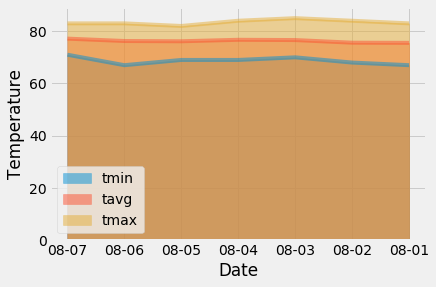

In [52]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked = False)
plt.xlabel('Date')
plt.ylabel('Temperature')

## Close Session

In [50]:
session.close()